In [1]:
import matplotlib.pyplot as plt
from BLEanalysis.synthetic import SignalDemo
from BLEanalysis.pathinference import Path_ProbabilityDensitiesToBee, Path_VectorsToBee
from BLEanalysis.kernels import ExponentiatedQuadraticKernel

demo = SignalDemo(sample_interval=300)
k = ExponentiatedQuadraticKernel(7.0,50.0)
path = Path_ProbabilityDensitiesToBee(demo.obstimes,demo.burst_observations,k,3.0,6)
path.run(200,learning_rate=2.0)#,just_optimise_means=True)

Standardising angles and times (shifting by 38.00 degrees)
Standardising angles and times (shifting by 38.00 degrees)
Optimising mean...
iteration    0:   23643.8
iteration   50:   19259.4
iteration  100:   19235.5
iteration  150:   19235.2
Optimising mean and covariance...
iteration    0:    4983.6
iteration   50:    4656.4
iteration  100:    4137.6
iteration  150:    2617.3


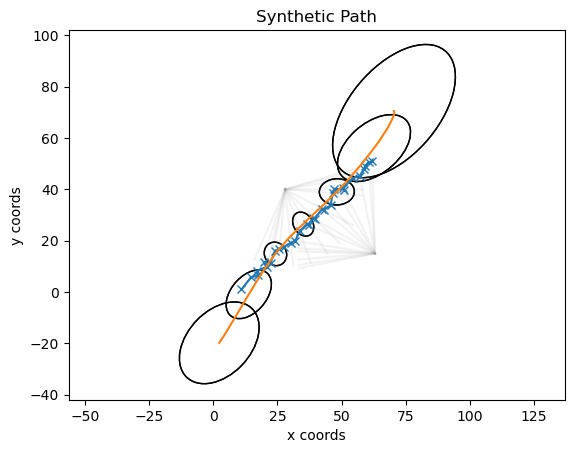

In [2]:
demo.plot()
path.plot(n_std=1)

## Comparison

As a quick comparison, here we find the mode of the angle distribution, and use that as a vector guess for inference, with the Path_VectorsToBee class: 

In [3]:
from BLEanalysis.angleinference import AnglesUsePatternMeans
angles = AnglesUsePatternMeans(noisevar=3**2)
import numpy as np
observations = []
for b in demo.burst_observations:
    logps,_,_,_ = angles.infer(b['rssis'],b['angles'])
    angle = np.linspace(0,np.pi*2,360)[np.argmax(logps)]
    obs = np.array([b['transmitter_position'][0],b['transmitter_position'][1],np.cos(angle),np.sin(angle)])
    observations.append(obs)
observations = np.array(observations)

Standardising angles and times (shifting by 38.00 degrees)


In [4]:
from BLEanalysis.pathinference import Path_VectorsToBee
path = Path_VectorsToBee(demo.obstimes,observations,k,6,0.1)
path.run(200,learning_rate=2.0)

Optimising mean...
iteration    0: 2827452.5
iteration   50:   62854.3
iteration  100:   53480.4
iteration  150:   50127.9
Optimising mean and covariance...
iteration    0:   82092.8
iteration   50:   30023.1
iteration  100:   28543.1
iteration  150:   28072.6


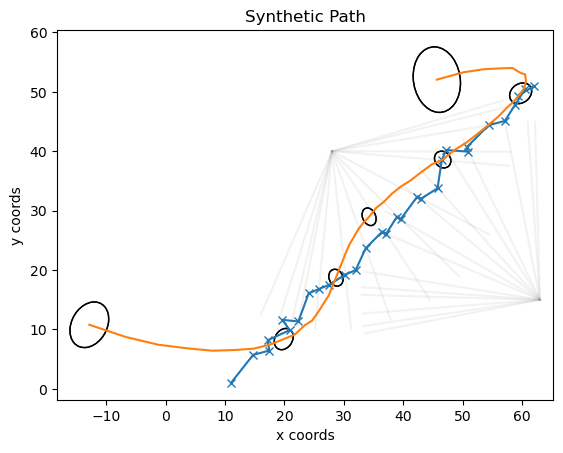

In [5]:
demo.plot()
path.plot(n_std=1)

# Note on the synthetic dataset

The observations consist of a list of dictionaries, each item contains:
 - the location of the transmitter
 - a list of RSSIs
 - a list of angles
TODO: A method in Signals should potentially generate this list from the data it has

In [71]:
x = 7
demo.burst_observations[x]

{'transmitter_position': array([63., 15.]),
 'rssis': array([-83.       , -79.       , -81.       , -82.       , -82.       ,
        -89.       , -85.       , -84.       , -80.1627907, -87.       ,
        -78.       , -79.       , -77.       , -84.       , -76.       ,
        -66.       , -64.       , -62.       , -65.       , -74.       ,
        -79.       , -74.       , -83.       , -82.       , -86.       ,
        -83.       , -87.       , -91.       , -86.       , -82.       ,
        -82.       , -80.       , -84.       , -80.1627907, -84.       ,
        -82.       , -83.       , -78.       , -77.       , -81.       ,
        -80.       , -78.       , -82.       , -81.       , -85.       ]),
 'angles': array([ 0.48195997,  0.67394618,  0.84847911,  0.98810545,  1.12773179,
         1.26735813,  1.42443776,  1.65133057,         nan,  1.89567666,
         2.12256946,  2.31455568,  2.41927544,  2.64616824,  2.7334347 ,
         2.92542092,  3.06504726, -3.095965  , -2.90397878,

To give an idea of the angle inference part of this, we will use the above data to infer the angle:

Standardising angles and times (shifting by 38.00 degrees)


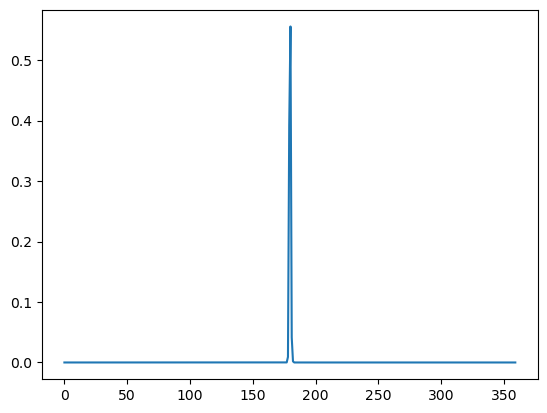

In [72]:
from BLEanalysis.angleinference import AnglesUsePatternMeans, normalise_logs_to_ps
angles = AnglesUsePatternMeans(noisevar=3**2)
import numpy as np
logps,_,_,_ = angles.infer(demo.burst_observations[x]['rssis'],demo.burst_observations[x]['angles'])
plt.plot(np.linspace(0,359,360),normalise_logs_to_ps(logps))

Trying out peak angle inference:

In [75]:
from BLEanalysis.angleinference import AnglesUsePeaks
angles = AnglesUsePeaks(100)
prediction = angles.infer(demo.burst_observations[x]['rssis'],demo.burst_observations[x]['angles'])

In [78]:
def normalize_degrees(angle):
    normalized = angle % 360
    return normalized if normalized >= 0 else normalized + 360

def normalize_radians(angle):
    normalized = angle % (2 * np.pi)
    return normalized if normalized >= 0 else normalized + 2 * np.pi

print(360 - normalize_degrees(np.rad2deg(prediction)))
print(2*np.pi - normalize_radians(prediction))

177.3857280283083
3.095965000141169


# Using Peak Signal Strengths

In [80]:
from BLEanalysis.angleinference import AnglesUsePeaks
demo = SignalDemo(sample_interval=150)
angles = AnglesUsePeaks(0)
observations = []
for b in demo.burst_observations:
    angle = angles.infer(b['rssis'],b['angles'])
    angle = (2*np.pi - normalize_radians(angle))
    obs = np.array([b['transmitter_position'][0],b['transmitter_position'][1],np.cos(angle),np.sin(angle)])
    observations.append(obs)

Standardising angles and times (shifting by 38.00 degrees)


In [81]:
observationsRemoveNan = []
obstimesRemoveNan = []

for x in range(len(observations)):
    if not np.isnan(observations[x][2]):
        observationsRemoveNan.append(observations[x])
        obstimesRemoveNan.append(demo.obstimes[x])

In [87]:
from BLEanalysis.pathinference import Path_VectorsToBee
k = ExponentiatedQuadraticKernel(7.0,50.0)
path = Path_VectorsToBee(np.array(obstimesRemoveNan),np.array(observationsRemoveNan),k,6,0.1)
path.run(300,learning_rate=2.0)

Optimising mean...
iteration    0: 2661958.0
iteration   50:   70076.7
iteration  100:   57110.3
iteration  150:   48639.9
iteration  200:   43561.4
iteration  250:   40895.3
Optimising mean and covariance...
iteration    0:   76143.1
iteration   50:   23034.1
iteration  100:   20955.3
iteration  150:   19904.8
iteration  200:   18861.3
iteration  250:   18945.3


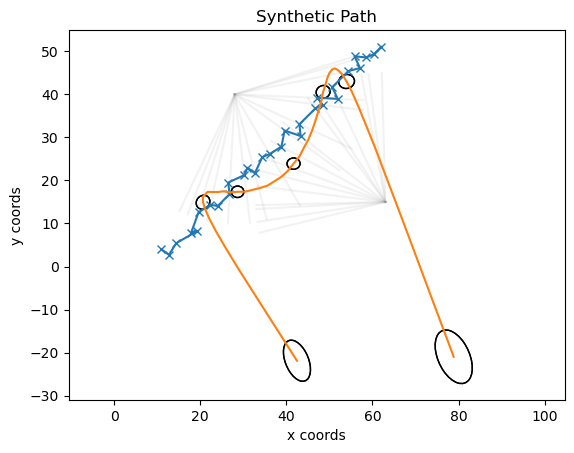

In [88]:
demo.plot()
path.plot(n_std=1)